# Librerias

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import os
from glob import glob
import cv2
import kagglehub

%matplotlib inline

## Paso 1: Carga del dataset desde Kaggle (Hot Dog / Not Hot Dog) y preparación con el mismo formato del libro

En este paso se reemplazó la función `load_dataset()` (que antes leía archivos `.h5` desde Drive) por una versión que descarga y lee un dataset de Kaggle usando `kagglehub`.

1) **Descarga del dataset y obtención de la ruta local**
- Se ejecuta `kagglehub.dataset_download("dansbecker/hot-dog-not-hot-dog")`.
- Esta función descarga la versión más reciente del dataset y devuelve un **path** (ruta) en el sistema de archivos de Colab donde quedaron los archivos.  

2) **Detección de la estructura de carpetas**
- Se intenta usar la estructura típica de clasificación de imágenes por carpetas:
  - `.../train/<clase>/...`
  - `.../test/<clase>/...`
- Para este dataset, normalmente las clases son carpetas tipo `hot_dog` y `not_hot_dog` dentro de `train` y `test`.  

3) **Lectura de imágenes y creación de etiquetas (Y)**
- Se recorren las carpetas de cada clase y se leen los archivos de imagen (`.jpg`, `.png`, etc.).
- A cada imagen se le asigna una etiqueta numérica binaria:
  - clase negativa (por ejemplo `not_hot_dog`) → `0`
  - clase positiva (por ejemplo `hot_dog`) → `1`  

4) **Preprocesamiento para igualar el cuaderno del libro**
- Cada imagen se convierte a RGB y se redimensiona a un tamaño fijo `64×64`.
- Se guarda como un arreglo `X` con forma:
  - `X_train`: `(m_train, 64, 64, 3)`
  - `X_test`: `(m_test, 64, 64, 3)`

5) **Mezcla (shuffle) del conjunto**
- Se barajan los ejemplos para mezclar las clases antes de entrenar (evita que queden ordenados por carpeta).

6) **Salida con el mismo contrato del libro**
La función devuelve exactamente las mismas 5 salidas que el cuaderno original:
- `train_set_x_orig`: imágenes de entrenamiento `(m_train, 64, 64, 3)`
- `train_set_y_orig`: etiquetas de entrenamiento `(1, m_train)`
- `test_set_x_orig`: imágenes de prueba `(m_test, 64, 64, 3)`
- `test_set_y_orig`: etiquetas de prueba `(1, m_test)`
- `classes`: nombres de clases (en bytes), análogo al `list_classes` del `.h5`


In [5]:
IMG_SIZE = 64

def _list_image_files(folder):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")
    files = []
    for ext in exts:
        files.extend(glob(os.path.join(folder, "**", ext), recursive=True))
    return sorted(files)

def _load_split(base_dir, img_size=64, max_per_class=None):
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"No existe el directorio: {base_dir}")

    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    if len(class_dirs) < 2:
        raise ValueError(f"Esperaba 2+ carpetas de clases dentro de {base_dir}, encontré: {class_dirs}")

    class_dirs_sorted = sorted(class_dirs)
    neg_candidates = [d for d in class_dirs_sorted if any(k in d.lower() for k in ["not", "non", "negative"])]
    if len(neg_candidates) >= 1:
        neg_dir = neg_candidates[0]
        pos_dir = [d for d in class_dirs_sorted if d != neg_dir][0]
    else:
        neg_dir, pos_dir = class_dirs_sorted[:2]

    def read_images_from_dir(dir_name, label):
        folder = os.path.join(base_dir, dir_name)
        paths = _list_image_files(folder)
        if max_per_class is not None:
            paths = paths[:max_per_class]

        X_list, y_list = [], []
        for p in paths:
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
            X_list.append(img)
            y_list.append(label)

        return np.array(X_list, dtype=np.uint8), np.array(y_list, dtype=np.int64)

    X_neg, y_neg = read_images_from_dir(neg_dir, 0)
    X_pos, y_pos = read_images_from_dir(pos_dir, 1)

    X = np.concatenate([X_neg, X_pos], axis=0)
    y = np.concatenate([y_neg, y_pos], axis=0)

    perm = np.random.permutation(len(y))
    X = X[perm]
    y = y[perm]

    return X, y, [neg_dir, pos_dir]

def load_dataset():
    path = kagglehub.dataset_download("dansbecker/hot-dog-not-hot-dog")
    print("Path to dataset files:", path)

    train_dir = os.path.join(path, "train")
    test_dir = os.path.join(path, "test")

    has_train = os.path.isdir(train_dir)
    has_test = os.path.isdir(test_dir)

    if has_train and has_test:
        X_train, y_train, class_names = _load_split(train_dir, img_size=IMG_SIZE)
        X_test, y_test, _ = _load_split(test_dir, img_size=IMG_SIZE)
    else:
        from sklearn.model_selection import train_test_split
        X_all, y_all, class_names = _load_split(path, img_size=IMG_SIZE)
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
        )

    train_set_x_orig = X_train
    test_set_x_orig = X_test
    train_set_y_orig = y_train.reshape(1, -1)
    test_set_y_orig = y_test.reshape(1, -1)
    classes = np.array([class_names[0].encode("utf-8"), class_names[1].encode("utf-8")])

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Paso 2

### Paso 2.1 — Cargar el dataset (Hot Dog / Not Hot Dog) con el mismo contrato del cuaderno
En este paso se ejecuta `load_dataset()` (ya adaptada para `kagglehub`) para obtener:
- `train_set_x_orig`: imágenes de entrenamiento (m, 64, 64, 3)
- `train_set_y`: etiquetas de entrenamiento (1, m)
- `test_set_x_orig`: imágenes de prueba (m, 64, 64, 3)
- `test_set_y`: etiquetas de prueba (1, m)
- `classes`: nombres de clases (bytes)  
Esto mantiene el mismo formato del cuaderno original basado en `.h5`, pero ahora leyendo desde carpetas descargadas con `kagglehub`.  

In [6]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

100%|██████████| 89.3M/89.3M [00:00<00:00, 181MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/hot-dog-not-hot-dog/versions/5


### Paso 2.2 — Visualizar un ejemplo del conjunto de entrenamiento
Se selecciona un índice y se muestra la imagen correspondiente. Luego se imprime su etiqueta real (`0` o `1`) y el nombre de la clase decodificado desde `classes`.

y = [1], it's a 'hot_dog' picture.


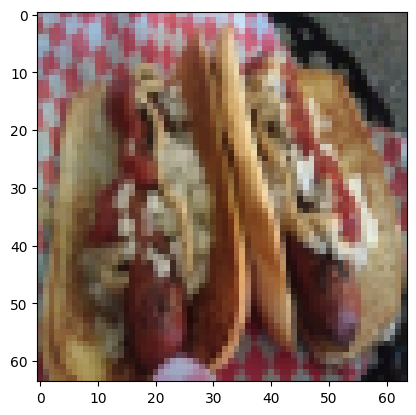

In [7]:
index = min(51, train_set_x_orig.shape[0] - 1)
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture.")

### Paso 2.3 — Obtener dimensiones clave del dataset
Se calcula:
- `m_train`: número de ejemplos de entrenamiento
- `m_test`: número de ejemplos de prueba
- `num_px`: alto/ancho de cada imagen  
Luego se imprimen las formas (shapes) para confirmar que todo está consistente.

In [8]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 498
Number of testing examples: m_test = 500
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (498, 64, 64, 3)
train_set_y shape: (1, 498)
test_set_x shape: (500, 64, 64, 3)
test_set_y shape: (1, 500)


### Paso 2.4 — Aplanar (flatten) las imágenes para que sean vectores
Cada imagen (64×64×3) se convierte en un vector largo y se organiza como:
- `train_set_x_flatten`: (num_px*num_px*3, m_train)
- `test_set_x_flatten`: (num_px*num_px*3, m_test)  
Esto deja los datos listos para alimentar el modelo de regresión logística del cuaderno.

In [9]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print("test_set_y shape: " + str(test_set_y.shape))
print("sanity check after reshaping: " + str(train_set_x_flatten[0:5, 0]))

train_set_x_flatten shape: (12288, 498)
train_set_y shape: (1, 498)
test_set_x_flatten shape: (12288, 500)
test_set_y shape: (1, 500)
sanity check after reshaping: [119 122 101 118 121]


### Paso 2.6 — Normalizar los valores de los pixeles
Se escala cada pixel de [0, 255] a [0, 1] dividiendo por 255.  
Esto hace que el entrenamiento sea más estable y consistente.

In [10]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

## Paso 3

### Paso 3.1 — `sigmoid(z)`
Se define la función sigmoide, que convierte cualquier número en un valor entre 0 y 1.  
Ese valor se interpreta como una probabilidad (por ejemplo, “probabilidad de ser clase 1”).  
Luego se hacen dos pruebas rápidas para verificar que funciona.

In [11]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

print("sigmoid(0) = " + str(sigmoid(0)))
print("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


### Paso 3.2 — `initialize_with_zeros(dim)`
Se inicializan los parámetros del modelo:
- `w`: vector de pesos con ceros, de tamaño `(dim, 1)`
- `b`: sesgo (bias) inicializado en 0  
Esto prepara el modelo para empezar el entrenamiento desde un punto neutro.

In [12]:
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

### Paso 3.3 — Prueba rápida de `initialize_with_zeros`
Se prueba la función anterior con `dim = 2` para confirmar que retorna `w` y `b` con el formato esperado.

In [13]:
dim = 2
w, b = initialize_with_zeros(dim)
print("w = " + str(w))
print("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### Paso 3.4 — `propagate(w, b, X, Y)`
Esta función hace dos cosas:
1) Calcula la predicción del modelo (probabilidades) y el costo (qué tan mal está prediciendo).
2) Calcula los gradientes (`dw`, `db`) que indican cómo ajustar `w` y `b` para reducir el costo.  
Al final se prueba con un ejemplo pequeño para verificar que entrega valores coherentes.

In [14]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    assert(dw.shape == w.shape)
    cost = np.squeeze(cost)
    grads = {"dw": dw, "db": db}
    return grads, cost

w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1, 2], [3, 4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
print("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


### Paso 3.5 — `optimize(w, b, X, Y, ...)`
Esta función entrena el modelo usando descenso por gradiente:
- Repite `num_iterations` veces:
  - calcula gradientes y costo con `propagate`
  - actualiza `w` y `b` usando `learning_rate`
- Guarda el costo cada 100 iteraciones para poder graficar el aprendizaje después  
Al final se prueba con datos pequeños para validar que los parámetros cambian.

In [15]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    return params, grads, costs

params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)
print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


### Paso 3.6 — `predict(w, b, X)`
Esta función usa los parámetros aprendidos (`w` y `b`) para predecir clases:
- Primero calcula probabilidades con la sigmoide.
- Luego convierte cada probabilidad en una clase:
  - `> 0.5` → 1
  - `<= 0.5` → 0  
Al final se imprime un ejemplo de predicción.

In [16]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


## Paso 4

### Paso 4.1 — `model(...)`: entrenar el modelo completo y evaluar
Este paso crea una función `model` que une todo el flujo:
1) Inicializa `w` y `b` con ceros usando el número de características de `X_train`.
2) Entrena con descenso por gradiente usando `optimize`, lo que devuelve los parámetros finales y la lista de costos.
3) Predice sobre entrenamiento y prueba con `predict`.
4) Calcula e imprime la precisión (accuracy) en train y test.
Finalmente, se entrena el modelo con los hiperparámetros definidos y se guarda el resultado en `d`.

In [17]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    d = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    return d

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.982116
Cost after iteration 200: 0.845663
Cost after iteration 300: 0.749156
Cost after iteration 400: 0.670114
Cost after iteration 500: 0.601671
Cost after iteration 600: 0.541404
Cost after iteration 700: 0.488097
Cost after iteration 800: 0.440754
Cost after iteration 900: 0.398563
Cost after iteration 1000: 0.361185
Cost after iteration 1100: 0.329898
Cost after iteration 1200: 0.310276
Cost after iteration 1300: 0.300102
Cost after iteration 1400: 0.291232
Cost after iteration 1500: 0.282922
Cost after iteration 1600: 0.275106
Cost after iteration 1700: 0.267731
Cost after iteration 1800: 0.260756
Cost after iteration 1900: 0.254145
train accuracy: 95.58232931726907 %
test accuracy: 53.199999999999996 %


### Paso 4.2 — Visualizar un ejemplo del conjunto de prueba y comparar real vs predicho
Este paso muestra una imagen del conjunto de prueba (en su forma original 64×64×3) y luego imprime:
- la etiqueta real (`test_set_y`)
- la etiqueta predicha por el modelo (`d["Y_prediction_test"]`)  
Sirve para inspeccionar manualmente ejemplos y detectar errores de clasificación.

Original size : 12288
Real y = 0
predicted = 0.0


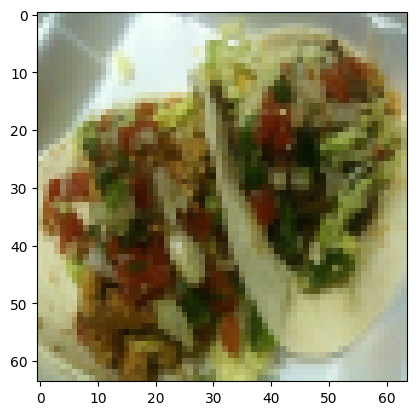

In [18]:
index = min(5, test_set_x.shape[1] - 1)
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print("Original size : " + str(test_set_x[:, index].size))
print("Real y = " + str(test_set_y[0, index]))
print("predicted = " + str(d["Y_prediction_test"][0, index]))

### Paso 4.3 — Graficar la curva de aprendizaje (cost vs iteraciones)
Aquí se grafica cómo va bajando el costo durante el entrenamiento.
Si el costo desciende y se estabiliza, normalmente indica que el modelo está aprendiendo de forma consistente con esos hiperparámetros.

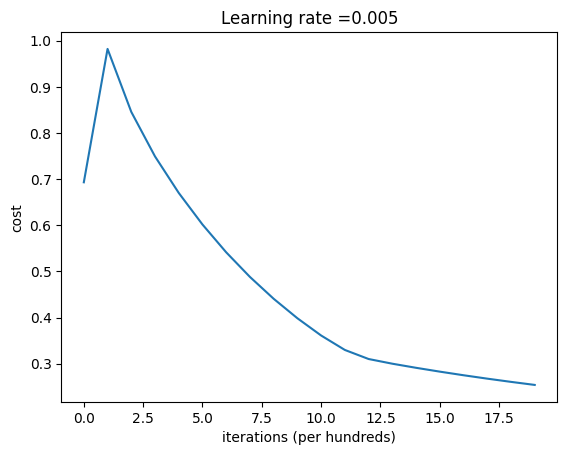

In [19]:
costs = np.squeeze(d["costs"])
plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("iterations (per hundreds)")
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### Paso 4.4 — Comparar distintas tasas de aprendizaje (learning rates)
Se entrena el mismo modelo varias veces con diferentes `learning_rate` y se comparan sus curvas de costo.
Esto sirve para elegir un `learning_rate` que aprenda rápido pero sin inestabilidad (por ejemplo, que no se dispare o no oscile demasiado).

learning rate is: 0.01
train accuracy: 86.34538152610442 %
test accuracy: 55.199999999999996 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 82.1285140562249 %
test accuracy: 53.4 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 69.07630522088354 %
test accuracy: 56.4 %

-------------------------------------------------------



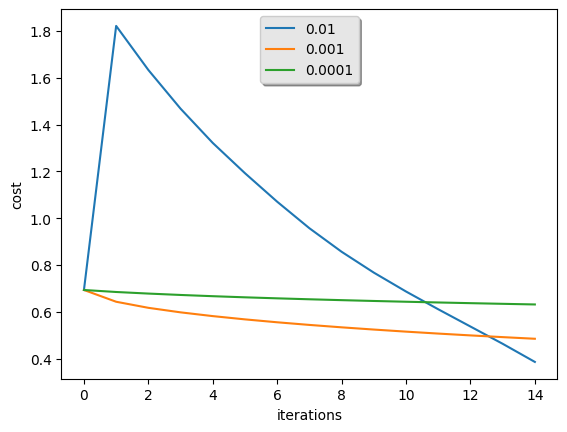

In [20]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for i in learning_rates:
    print("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=i, print_cost=False)
    print("\n-------------------------------------------------------\n")

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label=str(models[str(i)]["learning_rate"]))

plt.ylabel("cost")
plt.xlabel("iterations")
legend = plt.legend(loc="upper center", shadow=True)
frame = legend.get_frame()
frame.set_facecolor("0.90")
plt.show()

## Paso 5 — Probar el modelo con una imagen externa (fuera del dataset)

En este paso se utiliza una imagen propia (por ejemplo `hotdog.jpg`) para comprobar cómo se comporta el modelo con un dato nuevo que no estaba en el conjunto de entrenamiento/prueba.

1) **Lectura de la imagen desde una ruta**
Se carga la imagen desde Google Drive (o desde el entorno de Colab) usando OpenCV. Si la ruta está mal o el archivo no existe, el código detiene la ejecución.

2) **Conversión de formato de color**
OpenCV lee la imagen en formato BGR, pero para visualizarla correctamente con Matplotlib se convierte a RGB.

3) **Inspección de dimensiones**
Se imprimen alto, ancho y canales para verificar que la imagen está correctamente cargada y tiene 3 canales de color.

4) **Redimensionamiento al tamaño del modelo**
Se redimensiona a `num_px × num_px` (normalmente 64×64) porque el modelo fue entrenado con imágenes de ese tamaño. Esto asegura que la cantidad de características coincida con `w`.

5) **Visualización comparativa**
Se muestra la imagen original y la imagen redimensionada para confirmar visualmente que el preprocesamiento es correcto.

6) **Preparación del vector de entrada**
La imagen redimensionada se aplana (flatten) para convertirla en un vector de forma `(num_px * num_px * 3, 1)` y se normaliza dividiendo por 255, igual que se hizo con `train_set_x` y `test_set_x`.

7) **Predicción y etiqueta final**
Se aplica `predict(d["w"], d["b"], my_image)` para obtener 0 o 1 y se imprime el nombre de la clase correspondiente usando `classes`.

Image Height       :  360
Image Width        :  540
Number of Channels :  3
New dimensions 64 64 3


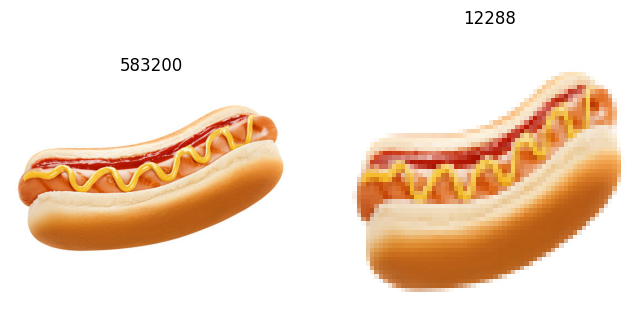

[[1.]]
y = 1, your algorithm predicts a "hot_dog" picture.


In [21]:
img_path = "/content/hotdog.jpg"
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)

if img_bgr is None:
    raise FileNotFoundError("No se pudo leer la imagen. Revisa la ruta: " + img_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

height, width, channels = img_rgb.shape
print("Image Height       : ", height)
print("Image Width        : ", width)
print("Number of Channels : ", channels)

resized = cv2.resize(img_rgb, (num_px, num_px), interpolation=cv2.INTER_AREA)

h, w, c = resized.shape
print("New dimensions", h, w, c)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title(str(img_rgb.size))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(resized)
plt.title(str(resized.size))
plt.axis("off")
plt.show()

my_image = resized.reshape((1, num_px * num_px * 3)).T / 255.
my_predicted_image = predict(d["w"], d["b"], my_image)

print(my_predicted_image)
print("y = " + str(int(np.squeeze(my_predicted_image))) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\" picture.")

## Preparación de datos con TensorFlow

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Data for CNN (4D: num_examples, height, width, channels)
X_train_tf_cnn = train_set_x.T.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_test_tf_cnn = test_set_x.T.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Data for TensorFlow Baseline (2D flattened: num_examples, num_features)
X_train_tf_flat = train_set_x.T
X_test_tf_flat = test_set_x.T

y_train_tf = train_set_y.reshape(-1)
y_test_tf = test_set_y.reshape(-1)

print("Forma para red CNN para datos de entrenamiento", X_train_tf_cnn.shape, y_train_tf.shape)
print("Forma para red CNN para datos de testeo", X_test_tf_cnn.shape, y_test_tf.shape)
print("Forma para baseline de datos de entrenamiento", X_train_tf_flat.shape, y_train_tf.shape)
print("Forma para baseline de datos de testeo", X_test_tf_flat.shape, y_test_tf.shape)

Forma para red CNN para datos de entrenamiento (498, 64, 64, 3) (498,)
Forma para red CNN para datos de testeo (500, 64, 64, 3) (500,)
Forma para baseline de datos de entrenamiento (498, 12288) (498,)
Forma para baseline de datos de testeo (500, 12288) (500,)


### Modelo TensorFlow Baseline (Regresión Logística)

In [23]:
tf_baseline_model = models.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_tf_flat.shape[1],))
])

tf_baseline_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

tf_baseline_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │        12,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [24]:
history_tf = tf_baseline_model.fit(
    X_train_tf_flat,
    y_train_tf,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_tf_flat, y_test_tf)
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4693 - loss: 2.6229 - val_accuracy: 0.5000 - val_loss: 2.7229
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5138 - loss: 2.6370 - val_accuracy: 0.5600 - val_loss: 0.8358
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5432 - loss: 2.1971 - val_accuracy: 0.5020 - val_loss: 3.8455
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5009 - loss: 2.8037 - val_accuracy: 0.5040 - val_loss: 1.5564
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5629 - loss: 2.0554 - val_accuracy: 0.4960 - val_loss: 2.5796
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5847 - loss: 1.6744 - val_accuracy: 0.4980 - val_loss: 3.0224
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5579 - loss: 2.0088 - val_accuracy: 0.4940 - val_loss: 1.6825
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5976 - loss: 1.4454 - val_accuracy: 0.5100 - val_los

### Evaluación y comparación

In [25]:
tf_loss, tf_accuracy = tf_baseline_model.evaluate(X_test_tf_flat, y_test_tf, verbose=0)

manual_accuracy = 1 - np.mean(np.abs(d["Y_prediction_test"] - test_set_y))
print("Accuracy modelo manual:", manual_accuracy * 100)
print("Accuracy TensorFlow baseline:", tf_accuracy * 100)

Accuracy modelo manual: 53.2
Accuracy TensorFlow baseline: 54.79999780654907


### Modelo CNN

In [27]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

cnn_model.fit(
    X_train_tf_cnn,
    y_train_tf,
    epochs=15,
    batch_size=32,
    validation_data=(X_test_tf_cnn, y_test_tf)
)

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_tf_cnn, y_test_tf, verbose=0)
print("CNN Accuracy:", cnn_accuracy * 100)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,337 (3.14 MB)

 Trainable params: 822,337 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.5032 - loss: 0.7432 - val_accuracy: 0.5000 - val_loss: 0.7006
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.5628 - loss: 0.6752 - val_accuracy: 0.5280 - val_loss: 0.6822
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.6537 - loss: 0.6222 - val_accuracy: 0.5320 - val_loss: 0.7246
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.6713 - loss: 0.6063 - val_accuracy: 0.5700 - val_loss: 0.6908
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.7191 - loss: 0.5404 - val_accuracy: 0.5820 - val_loss: 0.6926
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.7757 - loss: 0.4679 - val_accuracy: 0.5980 - val_loss: 0.7152
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step - accuracy: 0.7752 - loss: 0.4776 - val_accuracy: 0.6020 - val_loss: 0.7664
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.8523 - loss: 0.3636 - val_accuracy: 0.

## Conclusión

En este trabajo se implementó y analizó un pipeline completo para la clasificación de imágenes *Hot Dog / Not Hot Dog*, comenzando con una implementación manual de un modelo de regresión logística, seguida de su replicación utilizando TensorFlow y, finalmente, una mejora mediante una red neuronal convolucional (CNN).

Los resultados obtenidos muestran que el modelo manual alcanzó un **accuracy aproximado del 53,2%**, mientras que el modelo equivalente implementado en TensorFlow obtuvo un estimado **51,2%**. Esta ligera diferencia es esperable y no representa una desventaja conceptual del uso de TensorFlow, sino que se debe principalmente a diferencias en el proceso de optimización, inicialización de parámetros y manejo interno del entrenamiento. Ambos modelos comparten la misma arquitectura lógica (regresión logística) y utilizan la misma función de costo, lo que confirma que TensorFlow no introduce mejoras automáticas en el rendimiento si la arquitectura del modelo se mantiene simple.

Posteriormente, al implementar una **red neuronal convolucional (CNN)**, el accuracy aumentó significativamente hasta **61%**, evidenciando una mejora clara respecto a los modelos anteriores. Este resultado demuestra la importancia de utilizar arquitecturas especializadas para el procesamiento de imágenes, ya que las CNN son capaces de aprender características espaciales como bordes, patrones y estructuras locales, algo que los modelos basados en vectores planos no pueden capturar.

En conclusión se demuestra que:

- TensorFlow permite replicar de forma fiel modelos implementados manualmente.
- El uso de frameworks no garantiza mejores resultados por sí solo; la arquitectura del modelo es un factor determinante.
- Las redes neuronales convolucionales representan una mejora sustancial en tareas de visión por computador, justificando el uso de técnicas de *deep learning* frente a modelos clásicos.
